In [0]:
import tensorflow as tf
tf.enable_eager_execution()

from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import numpy as np
from tensorflow.python.keras import models
from scipy.optimize import fmin_l_bfgs_b

from IPython import display
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, BatchNormalization, Dropout,Add

# Style Transfer: Beta Version

This document is for **arbitrary** images neural style(**fixed**) transfer. Our work is based on our alpha version and [Johnson's paper](https://arxiv.org/abs/1603.08155) .  (Note: Implementation is based on **tensorflow eager execution**)

## Step 1: Read and Preprocess Image

### (a) Read images

In [0]:
# Here, upload our zip file!
!unzip 'train2014.zip'

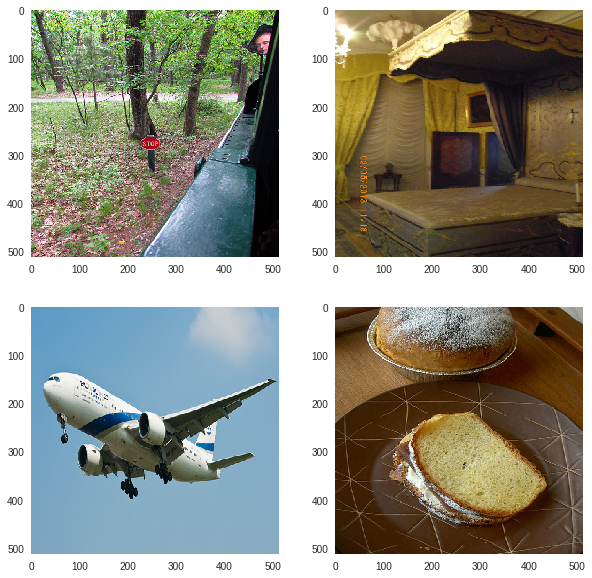

In [3]:
# Read images from folder
height = 512
width  = 512

from os import listdir

def loadImages(path):
  """This function will load images from folder
  
  Arguments:
    path: the folder path
      
  Returns:
    returns a list contains all images
  """
  imagesList = listdir(path)
  loadedImages = []
  for image in imagesList:
    if image[::-1][:4] == '.jpg'[::-1]:
      img = Image.open(path + image)
      img = img.resize((width, height))
      loadedImages.append(img)
  return loadedImages
  
path = "./train2014/"
content_images = loadImages(path)
n=len(content_images)
# randomly show four images in our dataset
plt.figure(figsize=(10,10))
for j,i in enumerate(np.random.choice(n,4)):
    plt.subplot(2,2,j+1)
    plt.imshow(content_images[i])
    plt.grid(False)

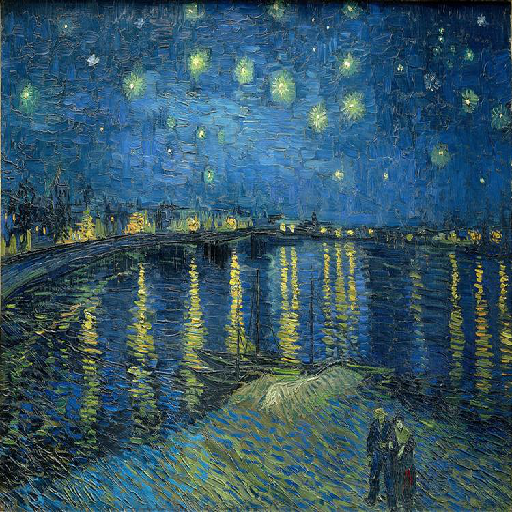

In [0]:
style_image_path = 'starry_night.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

### (b) Preprocess images

In [0]:
# Get np.array for our content training dataset 
content_array = np.zeros(shape=(n, width, height, 3), dtype='float32')
for i in range(n):
  content_array[i,:,:,:] = np.asarray(content_images[i], dtype='float32')
  
style_array   = np.asarray(style_image, dtype='float32')
print(content_array.shape)
print(style_array.shape)

Then, we have to preprocess content images by using two methods because the scale of the input for `TransformNet` should be [0,1] but the input for `VGG16` should be subtracted means vector.

In [0]:
# # Get the input for transform_net
# content_array=content_array[:4,:,:,:]
x_array=content_array/255

In [0]:
# Get the input for vgg16
means = np.mean(content_array, tuple(range(3))); print('means: ', means)
content_array -= means
style_array -= means

means:  [102.48506  99.58588  68.2138 ]


In [0]:
# content_array = np.expand_dims(content_array, axis=0)
style_array = np.expand_dims(style_array, axis=0)
print(content_array.shape)
print(style_array.shape)

(4, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
#dataset = tf.data.Dataset.from_tensor_slices(content_array2).shuffle(10).batch(4).prefetch(1)

## Step 2: Model 1 Transform Net

In [0]:
class TransformNet(tf.keras.Model):
  def __init__(self):
    super(TransformNet, self).__init__()
    # encode block
    self.block1_conv1 = Conv2D(filters=32, kernel_size=(9,9), strides=1, padding="same")
    self.block1_batchnorm1 = BatchNormalization(axis=3)
    self.block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding="same")
    self.block1_batchnorm2 = BatchNormalization(axis=3)
    self.block1_conv3 = Conv2D(filters=128, kernel_size=(3,3), strides=2, padding="same")
    self.block1_batchnorm3 = BatchNormalization(axis=3)
    # residual net block
    self.block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm1 = BatchNormalization(axis=3)
    self.block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm2 = BatchNormalization(axis=3)
    self.block2_add1 = Add()
    self.block2_conv3 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm3 = BatchNormalization(axis=3)
    self.block2_conv4 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm4 = BatchNormalization(axis=3)
    self.block2_add2 = Add()
    self.block2_conv5 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm5 = BatchNormalization(axis=3)
    self.block2_conv6 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm6 = BatchNormalization(axis=3)
    self.block2_add3 = Add()
    self.block2_conv7 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm7 = BatchNormalization(axis=3)
    self.block2_conv8 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm8 = BatchNormalization(axis=3)
    self.block2_add4 = Add()
    self.block2_conv9 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm9 = BatchNormalization(axis=3)
    self.block2_conv10 = Conv2D(filters=128, kernel_size=(3,3), padding="same")
    self.block2_batchnorm10 = BatchNormalization(axis=3)
    self.block2_add5 = Add()
    # decode block
    self.block3_conv1transpose = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, padding="same")
    self.block3_batchnorm1 = BatchNormalization(axis=3)
    self.block3_conv2transpose = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, padding="same")
    self.block3_batchnorm2 = BatchNormalization(axis=3)
    self.block3_conv3transpose = Conv2D(filters=3, kernel_size=(9,9), strides=1, padding="same")
    self.block3_batchnorm3 = BatchNormalization(axis=3)
    
  def call(self, x, training=True):
    # encode block
    x = tf.reshape(x,(-1,512,512,3))
    x = self.block1_conv1(x)
    x = tf.nn.relu(x)
    x = self.block1_batchnorm1(x, training=training)
    x = self.block1_conv2(x)
    x = tf.nn.relu(x)
    x = self.block1_batchnorm2(x, training=training)
    x = self.block1_conv3(x)
    x = tf.nn.relu(x)
    x = self.block1_batchnorm3(x, training=training)
    
    # residual block
    x1 = x
    x = self.block2_conv1(x)
    x = self.block2_batchnorm1(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_conv2(x)
    x = self.block2_batchnorm2(x,training=training)
    x = self.block2_add1([x, x1])
    x1 = x
    x = self.block2_conv3(x)
    x = self.block2_batchnorm3(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_conv4(x)
    x = self.block2_batchnorm4(x,training=training)
    x = self.block2_add2([x, x1])
    x1 = x
    x = self.block2_conv5(x)
    x = self.block2_batchnorm5(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_conv6(x)
    x = self.block2_batchnorm6(x,training=training)
    x = self.block2_add3([x, x1])
    x1 = x
    x = self.block2_conv7(x)
    x = self.block2_batchnorm7(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_conv8(x)
    x = self.block2_batchnorm8(x,training=training)
    x = self.block2_add4([x, x1])
    x1 = x
    x = self.block2_conv9(x)
    x = self.block2_batchnorm9(x,training=training)
    x = tf.nn.relu(x)
    x = self.block2_conv10(x)
    x = self.block2_batchnorm10(x,training=training)
    x = self.block2_add5([x, x1])
    
    # decode block
    x = self.block3_conv1transpose(x)
    x = tf.nn.relu(x)
    x = self.block3_batchnorm1(x,training=training)
    x = self.block3_conv2transpose(x)
    x = tf.nn.relu(x)
    x = self.block3_batchnorm2(x,training=training)
    x = self.block3_conv3transpose(x)
    x = (tf.nn.tanh(x)+1)*127.5  
    #so as to input vgg16, this idea comes from 
    # https://github.com/malhagi/tensorflow-fast-neuralstyle
    return x

## Step 3: Model 2 VGG16

In [0]:
class VGG16_Model(tf.keras.Model):
  def __init__(self):
    super(VGG16_Model, self).__init__()
    self.vgg16 = tf.keras.applications.vgg16.VGG16(input_shape=(512, 512, 3), include_top=False)
  
  def call(self, x, training=True):
    self.vgg16.trainable=False
    content_outputs = [self.vgg16.get_layer(l).output for l in layers_content]  # 0 content features
    style_outputs   = [self.vgg16.get_layer(l).output for l in layers_style]    # 1: style features
    outputs = content_outputs + style_outputs
    model=models.Model(self.vgg16.input,outputs)
    x = model(x)
    return x

In [0]:
transform_net= TransformNet()
vgg16 = VGG16_Model()

## Step 4: Compute Loss

This part is similar to alpha version and Gatys' paper. 

In [0]:
def content_loss(y_hat_features,content_features):
  """This function will compute content loss
  
  Arguments:
    y_hat_features: transform_net output image features
    content_features: content image features
      
  Returns:
    returns content loss
  """
  _,h,w,N = content_features.shape
  M=tf.cast(tf.multiply(h,w),tf.float32)
  N=tf.cast(N,tf.float32)
  norm=tf.divide(1,tf.multiply(M,N))
  content_l = tf.reduce_sum(tf.square(y_hat_features-content_features))
  return tf.multiply(norm, content_l)

In [0]:
def gram_matrix(feature_tensor):
  """This function will compute gram matrix based on Gatys paper
  
  Arguments:
    feature_tensor: feature tensor
      
  Returns:
    returns gram matrix
    
  """
  channel = int(feature_tensor.shape[-1])
  feature_2d=feature_tensor[0,:,:,:]
  feature_2d=tf.reshape(feature_tensor, [-1, channel])
  feature_2d=tf.matmul(feature_2d, feature_2d, transpose_a=True)
  return feature_2d

In [0]:
def style_loss_per_layer(y_hat_features,style_features):
  """This function will compute style loss for a specific layer
  
  Arguments:
    y_hat_features: transform_net output image features
    style_features: style image features
      
  Returns:
    returns style loss for each layer
  
  """
  y_hat_gram=gram_matrix(y_hat_features)
  style_gram=gram_matrix(style_features)
  _,h,w,N,=style_features.shape
  M=tf.cast(tf.multiply(h,w),tf.float32)
  N=tf.cast(N,tf.float32)
  norm=tf.divide(1,tf.multiply(M,N))
  norm=tf.pow(norm,2)
  style_l=tf.reduce_sum(tf.square(style_gram-y_hat_gram))
  return tf.multiply(norm,style_l)

In [0]:
def style_loss(y_hat_features_lst, style_features_lst):
  """This function will compute total style loss
  
  Arguments:
    y_hat_features_lst: transform_net image features for many layers
    style_features_lst: style image features for many layers
      
  Returns:
    returns total style loss
  
  """
  style_score=0
  style_weight_per_layer=1.0/float(len(style_features_lst))  #uniformly
  for i in range(len(style_features_lst)):
    style_loss_single=style_loss_per_layer(y_hat_features_lst[i],style_features_lst[i])
    style_score += style_weight_per_layer * style_loss_single
  return style_score

In [0]:
def variation_loss(y_hat,height,width,beta):
  """This function will compute variation loss
  
  Arguments:
    y_hat: transform_net output 
    height: image height
    width: image width
      
  Returns:
    returns variation loss
  
  Note: variation loss is a regularisation term that encourages spatial smoothness.
        this idea comes from this paper: https://arxiv.org/abs/1412.0035
  
  """
  a = tf.square(y_hat[:, :height-1, :width-1, :] - y_hat[:, 1:, :width-1, :])   
  b = tf.square(y_hat[:, :height-1, :width-1, :] - y_hat[:, :height-1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, beta/2))

In [0]:
def compute_loss(model,y_hat,content_image,style_image,
                 content_weight,style_weight,variation_weight,beta):
  
  """This function will compute total loss
  
  Arguments:
    model: the hidden model we build
    y_hat: transform_net output and vgg16 input
    content_image: content image(numpy array)
    style_image: style image(numpy array)
    content_weight, style_weight, variation_weight: weights
    beta: beta parameter for variation loss
      
  Returns:
    returns total loss
  
  """
  
  y_hat -= means
  content_features=model(content_image) 
  style_features_lst=model(style_image)
  y_hat_features=model(y_hat)                
  
  loss_c = content_loss(y_hat_features[0], content_features[0])
  loss_s = style_loss(y_hat_features[1:], style_features_lst[1:])
  loss_var = variation_loss(y_hat, height, width, beta)
  l = content_weight * loss_c + style_weight * loss_s + variation_weight * loss_var
  #l = content_weight * loss_c
  return l, loss_c, loss_s, loss_var

## Step 5: Create Train Operation

In [0]:
opt = tf.train.AdamOptimizer(learning_rate=1e-3)

In [0]:
def train_step(model,x_image,content_image,style_image):
  
  with tf.GradientTape() as tape:
    
    y_hat = transform_net(x_image, training=True)
    total_loss, loss_c, loss_s, loss_var =compute_loss(model,y_hat,content_image,style_image,
                            content_weight,style_weight,variation_weight,beta)

  grads = tape.gradient(total_loss, transform_net.variables)
  opt.apply_gradients(zip(grads, transform_net.variables))
  return total_loss, loss_c, loss_s, loss_var

In [0]:
# Compile the training step with defun for increased performance(graph mode)
train_step = tf.contrib.eager.defun(train_step)

In [0]:
tfe = tf.contrib.eager

In [0]:
def generate_and_display():
  display.clear_output(wait=True)
  y_hats = transform_net(x_array,training=False)
  #print(y_hats[0])
  imgs=[]
  for i in range(y_hats.shape[0]):
    #y_hat=y_hats[i,:,:,:]+means
    #y_hat=y_hats[i,:,:,:]*255
    #y_hat = y_hat[:, :,::-1]
    y_hat = np.array(y_hats[i,:,:,:],dtype='uint8')
    #y_hat *= np.expand_dims([0.229, 0.224, 0.225],axis=0)
    #y_hat += np.expand_dims([0.485, 0.456, 0.406],axis=0)
    #y_hat *= 255
    #y_hat = np.clip(y_hat,0,255).astype('uint8')
    imgs.append(y_hat)
  
  #fig = plt.figure(figsize=(10,10))
  fig =plt.figure(figsize=(20,10))
  for i in range(len(imgs)):  
    plt.subplot(5,(len(imgs)//5)+1, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
  plt.show()  

In [0]:
epochs = 30
content_weight=100
#style_weight=0.025
#style_weight=0.1   # 4 is 0.1
style_weight=0.3
variation_weight=1e-4
beta=2.5

layers_content = ['block2_conv2']
layers_style = ['block1_conv2', 'block2_conv2','block3_conv2', 'block4_conv2','block5_conv2']

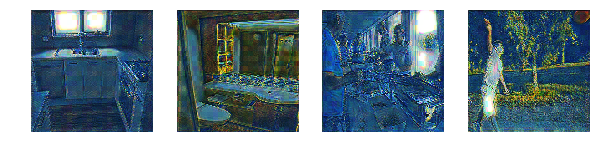

Epoch 499. Seconds 2.322932243347168
Epoch 499. Total Loss 14124559.0
Epoch 499. Content Loss 11373692.0
Epoch 499. Style Loss 1863313.625
Epoch 499. Variation Loss 887553.1875


In [0]:
for epoch in range(epochs):
  start = time.time()
  for i in range(x_array.shape[0]):
    l_t, loss_c, loss_s, loss_var=train_step(vgg16,np.expand_dims(x_array[i],axis=0),
                                             np.expand_dims(content_array[i],axis=0),style_array)
  #l_t, loss_c, loss_s, loss_var=train_step(vgg16,content_array1,content_array2,style_array)
  end = time.time()
  generate_and_display()
  print ('Epoch {}. Seconds {}'.format(epoch, end - start))
  print ('Epoch {}. Total Loss {}'.format(epoch,l_t))
  print ('Epoch {}. Content Loss {}'.format(epoch,content_weight*loss_c))
  print ('Epoch {}. Style Loss {}'.format(epoch,style_weight*loss_s))
  print ('Epoch {}. Variation Loss {}'.format(epoch,variation_weight*loss_var))
  #print ('Epoch {}. Grads {}'.format(epoch,grads))

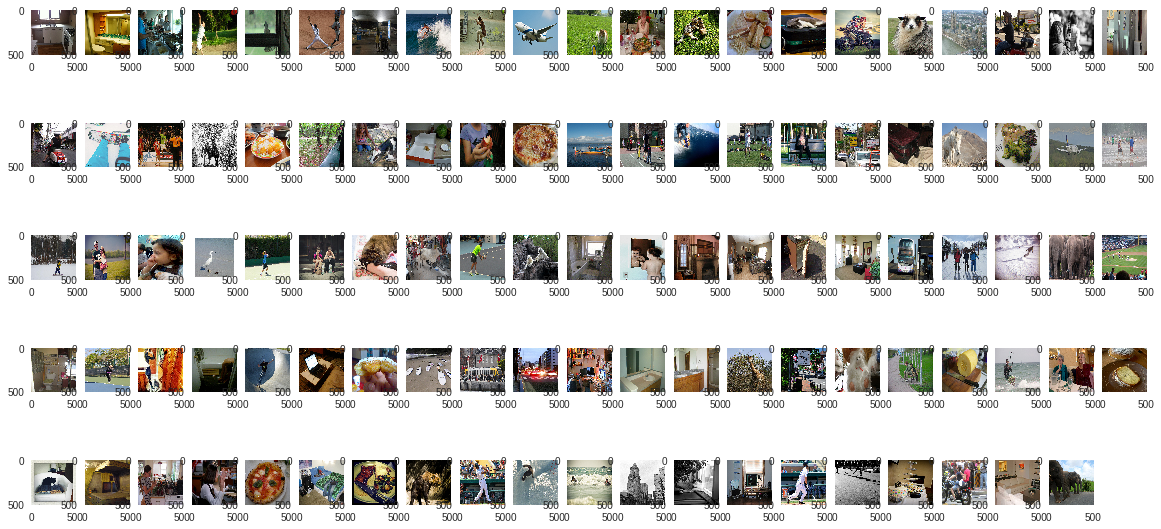

In [8]:
# Show original dataset
plt.figure(figsize=(20,10))
for j,i in enumerate(x_array):
    plt.subplot(5,(len(x_array)//5)+1,j+1)
    plt.imshow(content_images[j])
    plt.grid(False)

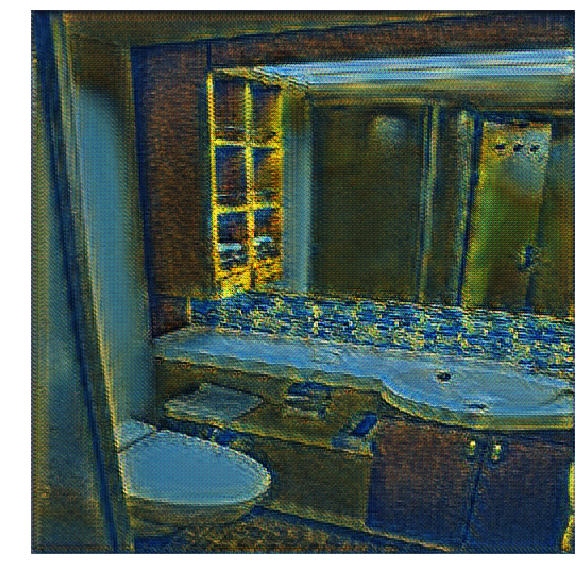

In [0]:
# Show one result from training dataset
result_img=transform_net(x_array,training=False)
result_img=result_img.numpy()[1,:,:,:]
# result_img=result_img[:,:,::-1]
plt.figure(figsize=(10,10))
plt.imshow(np.clip(result_img,0,255).astype('uint8'))
plt.grid(False)
plt.axis('off')
#plt.savefig("content_beta.png",bbox_inches='tight')

## Step 6: Fast Style Transfer 

Here, we perform style transfer for a new image by using our trained `transform_net`. 

In [0]:
from tensorflow.python.keras.preprocessing import image as kp_image

test_path = 'central_park.jpg'
test_image = Image.open(test_path)
# preprocess image
test_image = test_image.resize((width, height))
test_image = kp_image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
test_image /= 255 

# transfer style
test_img=transform_net(test_image,training=False)
test_img=test_img.numpy()
test_img=test_img[0,:,:,:]

# show the result
plt.figure(figsize=(10,10))
plt.imshow(np.clip(test_img,0,255).astype('uint8'))
plt.grid(False)
plt.axis('off')
plt.savefig("central_park_beta.png",bbox_inches='tight')

TODO(12.10):
* Change batch_normalization into instance_normalization. 
* Change dataset for batch training. 
* If change RGB to BGR for vgg input. 